In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp "/content/drive/My Drive/datasets/super-res-large.zip" "dataset.zip"
!unzip -q  dataset.zip 

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model

Using TensorFlow backend.


In [ ]:
db_dir = "dataset-lg"

In [ ]:
def get_train_data():
    X = []
    Y = []
    for x in os.listdir(db_dir + "/train/lr"):
        img_x = cv2.imread(db_dir + "/train/lr/" + x)
        X.append(img_x)
    
    X = np.array(X) / 255
        
    for y in os.listdir(db_dir + "/train/hr"):
        img_y = cv2.imread(db_dir + "/train/hr/" + y)
        Y.append(img_y)
    Y = np.array(Y) / 255 
    
    return X,Y


train_lr, train_hr = get_train_data()

In [ ]:
def get_test_data():
    X = []
    Y = []
    for x in os.listdir(db_dir + "/test/lr"):
        img_x = cv2.imread(db_dir + "/test/lr/" + x)
        X.append(img_x)
    
    X = np.array(X) / 255
        
    for y in os.listdir(db_dir + "/test/hr"):
        img_y = cv2.imread(db_dir + "/test/hr/" + y)
        Y.append(img_y)
    
    Y = np.array(Y) / 255
    
    return X,Y


test_lr, test_hr = get_test_data()

In [ ]:
print("train_shape ", train_lr.shape, " test_shape ", test_lr.shape )

num_res_block = 16
hr_shape = (train_hr.shape[1], train_hr.shape[2], train_hr.shape[3])
lr_shape = (train_lr.shape[1], train_lr.shape[2], train_lr.shape[3])


Conv2D = layers.Conv2D
BatchNormalization = layers.BatchNormalization
PReLU = layers.PReLU
UpSampling2D = layers.UpSampling2D
Dense = layers.Dense
add = layers.add
LeakyReLU = layers.LeakyReLU
Input = layers.Input
Flatten = layers.Flatten


lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

train_shape  (2500, 25, 25, 3)  test_shape  (500, 25, 25, 3)


## Generator

In [ ]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

## Discriminator

In [ ]:


def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    
    return disc_model
    

## Generator model

In [ ]:
def create_gen(gen_ip):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

## Discriminator model

In [ ]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)
    


## VGG19

In [ ]:
from keras.applications import VGG19

def build_vgg():
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]

    img = Input(shape=hr_shape)

    img_features = vgg(img)

    return Model(img, img_features)



## Combined Model

In [ ]:

def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [ ]:

generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

vgg = build_vgg()
vgg.trainable = False


gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1], optimizer="adam")



In [ ]:
# discriminator.summary()
# generator.summary()
gan_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 25, 3)    0                                            
__________________________________________________________________________________________________
model_9 (Model)                 (None, 100, 100, 3)  2044291     input_1[0][0]                    
__________________________________________________________________________________________________
model_10 (Model)                (None, 1)            30384961    model_9[1][0]                    
__________________________________________________________________________________________________
model_11 (Model)                (None, 25, 25, 256)  143667240   model_9[1][0]                    
Total params: 176,096,492
Trainable params: 2,040,067
Non-trainable params: 174,056,425
___

In [ ]:
batch_size = 50
train_lr_batches = []
train_hr_batches = []
for it in range(int(train_hr.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_hr[start_idx:end_idx])
    train_lr_batches.append(train_lr[start_idx:end_idx])

In [ ]:

epochs = 100
for e in range(epochs):
    
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        
        gen_imgs = generator.predict_on_batch(lr_imgs)
        
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(gen_imgs, gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        discriminator.trainable = False
        
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        image_features = vgg.predict(hr_imgs)

        
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 20 == 0:
        discriminator.save_weights("drive/My Drive/models/sr/disc/e_"+ str(e+1) +".h5")
        generator.save_weights("drive/My Drive/models/sr/gen/e_"+ str(e+1) +".h5")


epoch: 1 g_loss: 9.701047897338867 d_loss: [5.237669e-05 1.000000e+00]
epoch: 2 g_loss: 9.740447044372559 d_loss: [1.412341e-06 1.000000e+00]
epoch: 3 g_loss: 9.862159729003906 d_loss: [1.6780416e-06 1.0000000e+00]
epoch: 4 g_loss: 9.851210594177246 d_loss: [1.7779879e-06 1.0000000e+00]
epoch: 5 g_loss: 9.807670593261719 d_loss: [1.7875698e-06 1.0000000e+00]
epoch: 6 g_loss: 9.793373107910156 d_loss: [1.756521e-06 1.000000e+00]
epoch: 7 g_loss: 9.50737476348877 d_loss: [1.7093275e-06 1.0000000e+00]
epoch: 8 g_loss: 9.449409484863281 d_loss: [1.6571793e-06 1.0000000e+00]
epoch: 9 g_loss: 9.228524208068848 d_loss: [1.6048066e-06 1.0000000e+00]
epoch: 10 g_loss: 9.136069297790527 d_loss: [1.5540896e-06 1.0000000e+00]
epoch: 11 g_loss: 9.083641052246094 d_loss: [1.5057043e-06 1.0000000e+00]
epoch: 12 g_loss: 9.022001266479492 d_loss: [1.4597786e-06 1.0000000e+00]
epoch: 13 g_loss: 9.018542289733887 d_loss: [4.641511e-05 1.000000e+00]
epoch: 14 g_loss: 9.032937049865723 d_loss: [1.9357237e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


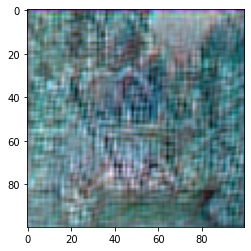

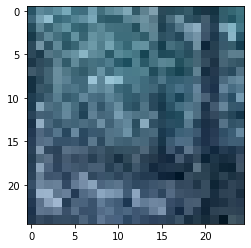

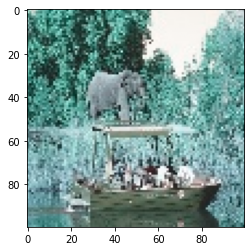

In [ ]:
res = generator.predict_on_batch(train_lr_batches[0])
plt.imshow(res[0])
plt.show()
plt.imshow(train_lr_batches[0][0])
plt.show()
plt.imshow(train_hr_batches[0][0])
plt.show()

In [ ]:
test_label = np.ones((len(test_lr),1))
test_imgs_features = vgg.predict(test_hr)
test_res = gan_model.evaluate([test_lr, test_hr], [test_label, test_imgs_features],10 )
print("Test loss & test Accuracy:", test_res)

50/50 [==============================] - 2s 33ms/step
Test loss & test Accuracy: [33.902625274658206, 0.7104344367980957, 33.90191650390625]


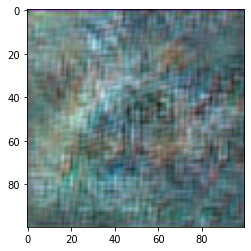

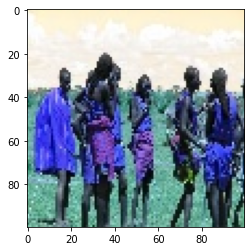

In [ ]:
test_gen = generator.predict_on_batch(test_lr)
plt.imshow(test_gen[10])
plt.show()
plt.imshow(test_hr[10])
plt.show()